##### Preparations

In [1]:
# If on kaggle, copy the contents of the "../input/" directory to the cwd of kaggle
def copy_if_kaggle():
    import os
    import shutil

    if os.getcwd() == "/kaggle/working":
        # Set the source directory
        src_dir = os.path.join("../input", os.listdir("../input")[0])
        # Copy all files from the source directory to the current directory
        for file_name in os.listdir(src_dir):
            shutil.copy(os.path.join(src_dir, file_name), ".")


# copy_if_kaggle()
# You can write up to 20GB to the cwd (/kaggle/working) that gets preserved as output when you push a version
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectPercentile
from sklearn.svm import LinearSVC
# from sklearn import set_config
# set_config(transform_output="pandas")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
%matplotlib inline
import seaborn as sns
import plotly.io as pio
pio.templates.default = "plotly_dark"
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
from statsmodels.stats.outliers_influence import variance_inflation_factor
import optuna

import warnings
warnings.filterwarnings('ignore')
import os
os.environ["PYTHONWARNINGS"] = "ignore"
# %%capture --no-stdout --no-display
# warnings.simplefilter("ignore")

In [3]:
# Plot styling
def my_dark_style():
    from cycler import cycler

    plt.style.use("default")
    plt.style.use(["dark_background", "bmh"])
    plt.rcParams["axes.facecolor"] = "#23272e"
    plt.rcParams["figure.facecolor"] = "#23272e"
    plt.rcParams["axes.prop_cycle"] = cycler(
        "color",
        [
            "#1c90d4",
            "#ad0026",
            "#530fff",
            "#429900",
            "#d55e00",
            "#ff47ac",
            "#42baff",
            "#009e73",
            "#fff133",
            "#0072b2",
        ],
    )
    # plt.rcParams['figure.figsize'] = 9, 7
    plt.rcParams["figure.autolayout"] = True


box_kws = dict(
    boxprops={"edgecolor": "#b2b2b2"},
    capprops={"color": "#b2b2b2"},
    flierprops={"markeredgecolor": "#b2b2b2"},
    medianprops={"color": "#b2b2b2"},
    whiskerprops={"color": "#b2b2b2"},
)
# # plt.rcParams['boxplot.boxprops.edgecolor'] = '#b2b2b2' no such rcParam
# plt.rcParams['boxplot.capprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.flierprops.markeredgecolor'] = '#b2b2b2'
# plt.rcParams['boxplot.medianprops.color'] = '#b2b2b2'
# plt.rcParams['boxplot.whiskerprops.color'] = '#b2b2b2'

my_dark_style()

In [4]:
# Load dataset
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
# train_data.name = "Train Set"
# test_data.name = "Test Set"


def joint_data():
    return pd.concat([train_data, test_data])


# Store our passenger ID for easy access
PassengerId = test_data.pop("PassengerId")
train_data.drop(columns="PassengerId", inplace=True)

# Initializing random seed (integer) and/or state (instance)
# pass seed to CV splitters (KFold, RepeatedKFold, etc.)
seed = 42
# pass rng to estimators and everything else;
# initialize a new rng for each estimator in order to prevent them from influencing each other by consuming the RNG
# rng = np.random.RandomState(seed)
# rng = np.random.default_rng(seed) # new numpy random Generator, not currently supported by sklearn

# If an integer is passed, calling fit or split multiple times always yields the same results.
# If a RandomState instance is passed: fit and split will yield different results each time they are called, and the succession of calls explores all sources of entropy.


### Overview

Nominal: `Survived, Sex, Embarked, Ticket`  
Ordinal: `Pclass`  
Continuous: `Age, Fare`  
Discrete: `SibSp, Parch` 

`Survived` - 0 = No, 1 = Yes  
`Pclass` is the ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd  
`SibSp` is the number of siblings / the number of spouses aboard the Titanic  
`Parch` is the number of parents / the number children aboard the Titanic  
`Embarked` is the port of embarkation	- C = Cherbourg, Q = Queenstown, S = Southampton  

In [5]:
print(train_data.info())
train_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
None


Survived  Pclass                                       Name     Sex  \
194         1       1  Brown, Mrs. James Joseph (Margaret Tobin)  female   
83          0       1                    Carrau, Mr. Francisco M    male   
86          0       3                     Ford, Mr. William Neal    male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
194  44.0      0      0    PC 17610  27.7208    B4        C  
83   28.0      0      0      113059  47.1000   NaN        S  
86   16.0      1      3  W./C. 6608  34.3750   NaN        S

In [6]:
print(test_data.info())
test_data.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB
None


Pclass                          Name   Sex   Age  SibSp  Parch  Ticket  \
318       3     Jonsson, Mr. Nils Hilding  male  27.0      0      0  350408   
128       2          Bowenur, Mr. Solomon  male  42.0      0      0  211535   
7         2  Caldwell, Mr. Albert Francis  male  26.0      1      1  248738   

        Fare Cabin Embarked  
318   7.8542   NaN        S  
128  13.0000   NaN        S  
7    29.0000   NaN        S

In [7]:
train_data.describe(include="all")

Survived      Pclass                     Name   Sex         Age  \
count   891.000000  891.000000                      891   891  714.000000   
unique         NaN         NaN                      891     2         NaN   
top            NaN         NaN  Braund, Mr. Owen Harris  male         NaN   
freq           NaN         NaN                        1   577         NaN   
mean      0.383838    2.308642                      NaN   NaN   29.699118   
std       0.486592    0.836071                      NaN   NaN   14.526497   
min       0.000000    1.000000                      NaN   NaN    0.420000   
25%       0.000000    2.000000                      NaN   NaN   20.125000   
50%       0.000000    3.000000                      NaN   NaN   28.000000   
75%       1.000000    3.000000                      NaN   NaN   38.000000   
max       1.000000    3.000000                      NaN   NaN   80.000000   

             SibSp       Parch  Ticket        Fare    Cabin Embarked  
count   891.000000  891.000000     891  891.000000      204      889  
unique         NaN         NaN     681         NaN      147        3  
top            NaN         NaN  347082         NaN  B96 B98        S  
freq           NaN         NaN       7         NaN        4      644  
mean      0.523008    0.381594     NaN   32.204208      NaN      NaN  
std       1.102743    0.806057     NaN   49.693429      NaN      NaN  
min       0.000000    0.000000     NaN    0.000000      NaN      NaN  
25%       0.000000    0.000000     NaN    7.910400      NaN      NaN  
50%       0.000000    0.000000     NaN   14.454200      NaN      NaN  
75%       1.000000    0.000000     NaN   31.000000      NaN      NaN  
max       8.000000    6.000000     NaN  512.329200      NaN      NaN

### Exploratory Data Analysis and Data Cleaning

##### Basic visualizations

Passengers with first-class tickets had the highest survival rate, while those in third class had the lowest survival rate.

<Axes: xlabel='Pclass', ylabel='count'>

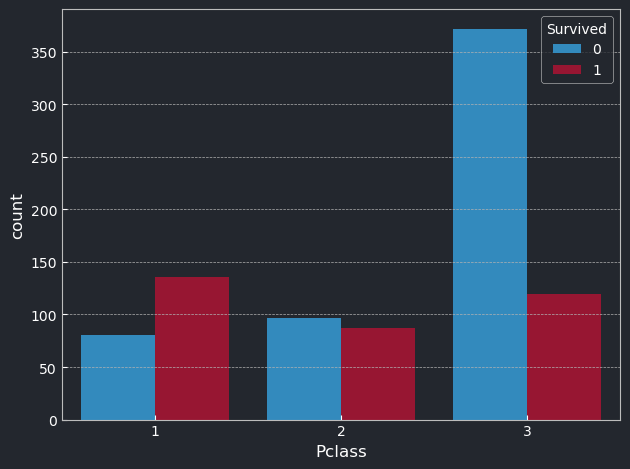

In [8]:
sns.countplot(train_data, x="Pclass", hue="Survived")

 The survival rate of females was significantly higher than that of men.

<Axes: xlabel='Sex', ylabel='count'>

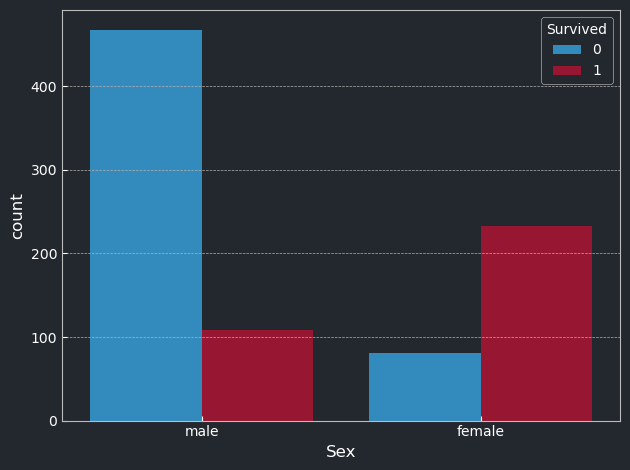

In [9]:
sns.countplot(train_data, x="Sex", hue="Survived")

 Passengers with no siblings/spouses/parents/children on board with them seem to have had a lower survival rate than those with a few companions.

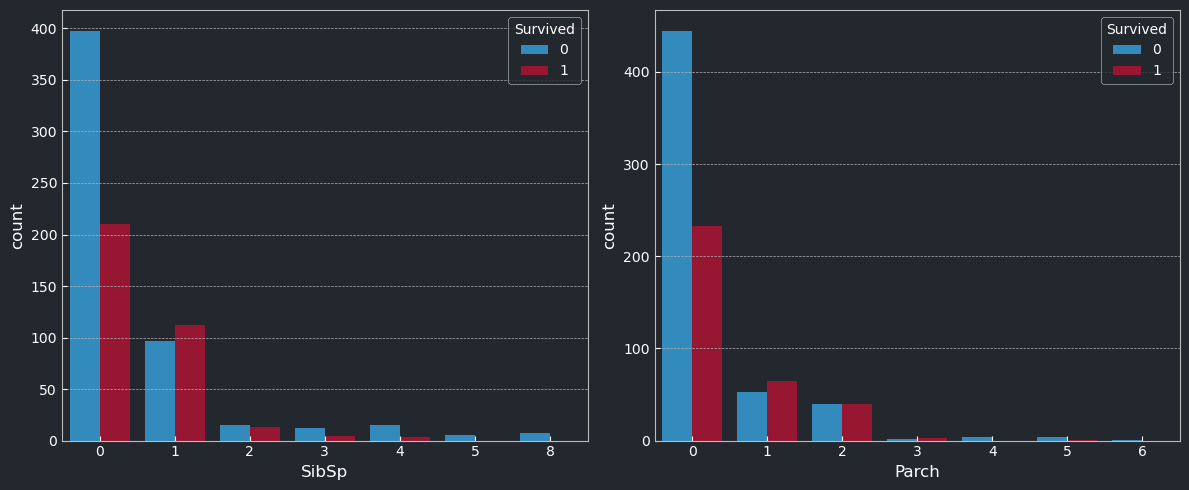

In [10]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, col in enumerate(["SibSp", "Parch"]):
    sns.countplot(train_data, x=col, hue="Survived", ax=axs[ax])

Those who embarked form the Southampton port had the lowest survival rate. Considering the numbers and order of embarkation (S->C->Q), it is also reasonable to assume that the majority of 3rd class passengers embarked form the Southampton port.

<Axes: xlabel='Embarked', ylabel='count'>

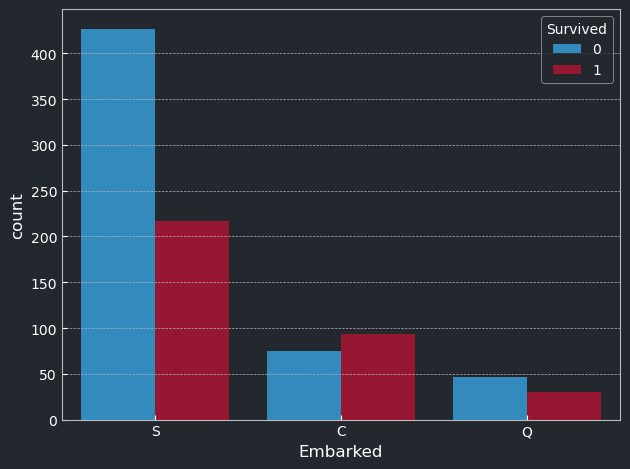

In [11]:
sns.countplot(train_data, x="Embarked", hue="Survived")

Children and elderly passengers had the highest survival rates, whereas those between the age of 20 and 30 had the lowest chance of surviving.

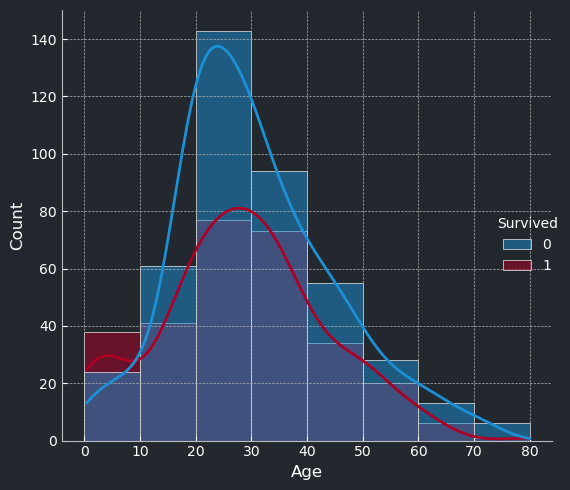

In [12]:
sns.displot(
    train_data, x="Age", hue="Survived", binwidth=10, binrange=(0, 80), kde=True
)

Those with the cheapest tickets had the lowest survival rate. The distribution is strongly skewed to the right. Most tickets costing below 10, and few cost above 100.

Text(0.5, 1.0, 'Log scale')

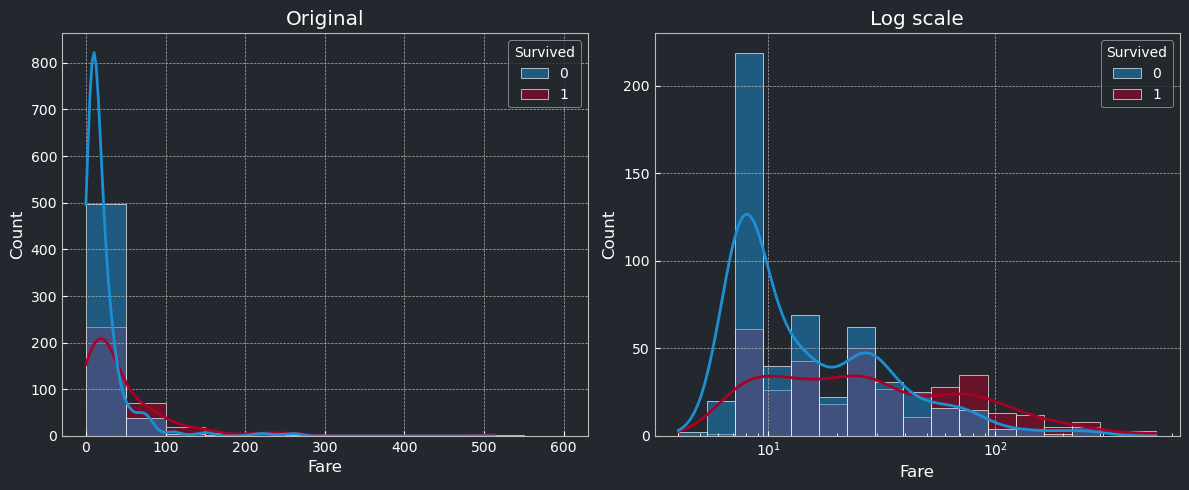

In [13]:
_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    train_data,
    x="Fare",
    hue="Survived",
    binwidth=50,
    binrange=(0, 600),
    kde=True,
    ax=axs[0],
)
sns.histplot(
    train_data[train_data.Fare > 0],
    x="Fare",
    hue="Survived",
    log_scale=True,
    kde=True,
    ax=axs[1],
)
axs[0].set_title("Original")
axs[1].set_title("Log scale")

##### Missing values

There are missing values in the `Age, Fare, Cabin` and `Embarked` features.

In [14]:
pd.DataFrame(
    [train_data.isna().sum(), test_data.isna().sum()], index=["Train", "Test"]
).T

Train   Test
Survived    0.0    NaN
Pclass      0.0    0.0
Name        0.0    0.0
Sex         0.0    0.0
Age       177.0   86.0
SibSp       0.0    0.0
Parch       0.0    0.0
Ticket      0.0    0.0
Fare        0.0    1.0
Cabin     687.0  327.0
Embarked    2.0    0.0

There is only one passenger with a missing `Fare` value. `Fare` is related to `Pclass`, `Embarked` and family size (`Parch` and `SibSp`) features. Median `Fare` value of a third class ticket with S as the port of embarkation for a passenger with no family is a logical choice to fill the missing value with.

In [15]:
test_data[test_data["Fare"].isna()]

Pclass                Name   Sex   Age  SibSp  Parch Ticket  Fare Cabin  \
152       3  Storey, Mr. Thomas  male  60.5      0      0   3701   NaN   NaN   

    Embarked  
152        S

In [16]:
# Blame black formatter for the lousy formatting..
test_data["Fare"].fillna(
    train_data.groupby(["Pclass", "Embarked", "Parch", "SibSp"]).Fare.mean()[3]["S"][0][
        0
    ],
    inplace=True,
)

It is worth noting, that some passengers have a `Fare` of 0. Ismay traveled on a complimentary ticket, as well as his servants (Fry and Harrison), Andrews and the Guarantee Group, and Reuchlin. Assuming that the rest of the passengers who hadn't paid for their tickets also received complimentary tickets, a separate 1/0 (True/False) feature `Complimentary` is created to indicate this.

In [17]:
joint_data()[joint_data().Fare == 0]

Survived  Pclass                                   Name   Sex   Age  \
179       0.0       3                    Leonard, Mr. Lionel  male  36.0   
263       0.0       1                  Harrison, Mr. William  male  40.0   
271       1.0       3           Tornquist, Mr. William Henry  male  25.0   
277       0.0       2            Parkes, Mr. Francis "Frank"  male   NaN   
302       0.0       3        Johnson, Mr. William Cahoone Jr  male  19.0   
413       0.0       2         Cunningham, Mr. Alfred Fleming  male   NaN   
466       0.0       2                  Campbell, Mr. William  male   NaN   
481       0.0       2       Frost, Mr. Anthony Wood "Archie"  male   NaN   
597       0.0       3                    Johnson, Mr. Alfred  male  49.0   
633       0.0       1          Parr, Mr. William Henry Marsh  male   NaN   
674       0.0       2             Watson, Mr. Ennis Hastings  male   NaN   
732       0.0       2                   Knight, Mr. Robert J  male   NaN   
806       0.0       1                 Andrews, Mr. Thomas Jr  male  39.0   
815       0.0       1                       Fry, Mr. Richard  male   NaN   
822       0.0       1        Reuchlin, Jonkheer. John George  male  38.0   
266       NaN       1  Chisholm, Mr. Roderick Robert Crispin  male   NaN   
372       NaN       1                Ismay, Mr. Joseph Bruce  male  49.0   

     SibSp  Parch  Ticket  Fare        Cabin Embarked  
179      0      0    LINE   0.0          NaN        S  
263      0      0  112059   0.0          B94        S  
271      0      0    LINE   0.0          NaN        S  
277      0      0  239853   0.0          NaN        S  
302      0      0    LINE   0.0          NaN        S  
413      0      0  239853   0.0          NaN        S  
466      0      0  239853   0.0          NaN        S  
481      0      0  239854   0.0          NaN        S  
597      0      0    LINE   0.0          NaN        S  
633      0      0  112052   0.0          NaN        S  
674      0      0  239856   0.0          NaN        S  
732      0      0  239855   0.0          NaN        S  
806      0      0  112050   0.0          A36        S  
815      0      0  112058   0.0         B102        S  
822      0      0   19972   0.0          NaN        S  
266      0      0  112051   0.0          NaN        S  
372      0      0  112058   0.0  B52 B54 B56        S

In [18]:
for data in [train_data, test_data]:
    data["Complimentary"] = data.Fare.apply(lambda x: 1 if x == 0 else 0)

joint_data()[joint_data().Fare == 0].sample(3)

Survived  Pclass                     Name   Sex   Age  SibSp  Parch  \
732       0.0       2     Knight, Mr. Robert J  male   NaN      0      0   
372       NaN       1  Ismay, Mr. Joseph Bruce  male  49.0      0      0   
806       0.0       1   Andrews, Mr. Thomas Jr  male  39.0      0      0   

     Ticket  Fare        Cabin Embarked  Complimentary  
732  239855   0.0          NaN        S              1  
372  112058   0.0  B52 B54 B56        S              1  
806  112050   0.0          A36        S              1

There are only 2 missing values for `Embarked`. Both passengers are upper class females from the same cabin and they have the same ticket number. In all likelihood, they are together and have embarked from the same port. A quick google search revealed the following information. *"Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was traveling in first class with her maid Amelie Icard. She occupied cabin B-28."*

In [19]:
train_data[train_data.Embarked.isna()]

Survived  Pclass                                       Name     Sex  \
61          1       1                        Icard, Miss. Amelie  female   
829         1       1  Stone, Mrs. George Nelson (Martha Evelyn)  female   

      Age  SibSp  Parch  Ticket  Fare Cabin Embarked  Complimentary  
61   38.0      0      0  113572  80.0   B28      NaN              0  
829  62.0      0      0  113572  80.0   B28      NaN              0

In [20]:
train_data["Embarked"].fillna("S", inplace=True)

`Age` missing values are imputed using the mean value from the nearest neighbors (using `Pclass, Sex, SibSp` and `Parch` as features, as they are likely indicators of age)

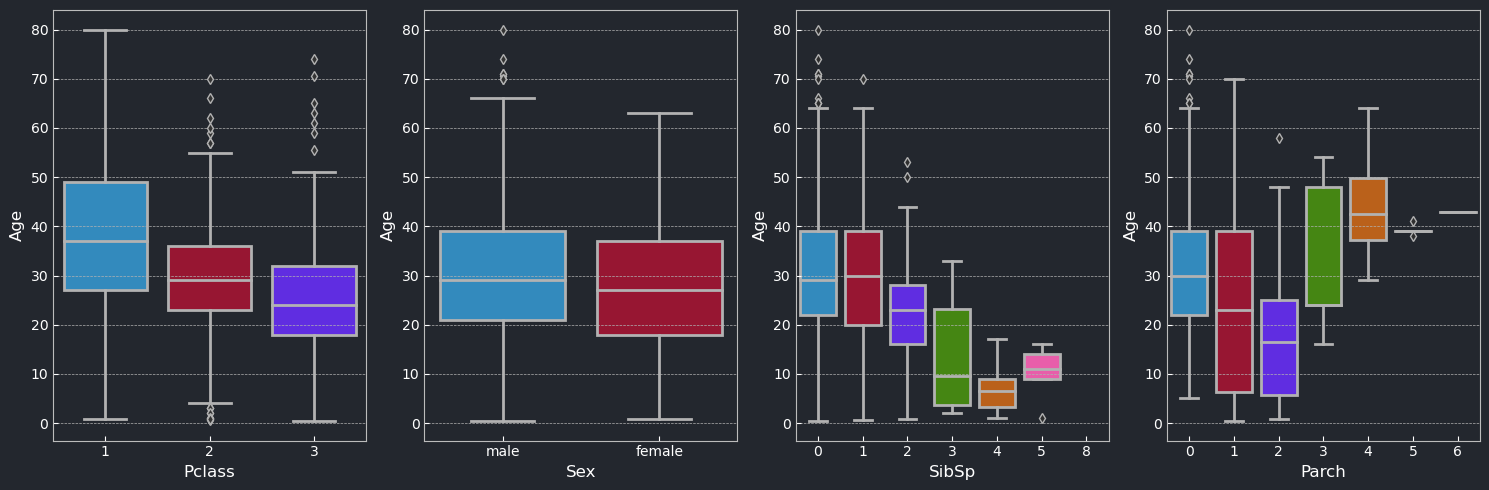

In [21]:
_, axs = plt.subplots(1, 4, figsize=(15, 5))
for ax, col in enumerate(["Pclass", "Sex", "SibSp", "Parch"]):
    sns.boxplot(
        train_data,
        x=col,
        y="Age",
        ax=axs[ax],
        # boxprops={"edgecolor": "#b2b2b2"},
        # capprops={"color": "#b2b2b2"},
        # flierprops={"markeredgecolor": "#b2b2b2"},
        # medianprops={"color": "#b2b2b2"},
        # whiskerprops={"color": "#b2b2b2"},
        **box_kws
    )

In [22]:
train_data[age_na := train_data["Age"].isna()].head(3)

Survived  Pclass                          Name     Sex  Age  SibSp  Parch  \
5          0       3              Moran, Mr. James    male  NaN      0      0   
17         1       2  Williams, Mr. Charles Eugene    male  NaN      0      0   
19         1       3       Masselmani, Mrs. Fatima  female  NaN      0      0   

    Ticket     Fare Cabin Embarked  Complimentary  
5   330877   8.4583   NaN        Q              0  
17  244373  13.0000   NaN        S              0  
19    2649   7.2250   NaN        C              0

In [23]:
neighbors = ["Age", "Pclass", "Sex", "SibSp", "Parch"]
# Encode `Sex`
ord_enc = OneHotEncoder(drop="if_binary", sparse_output=False)
train_data["Sex"] = ord_enc.fit_transform(train_data[["Sex"]])
test_data["Sex"] = ord_enc.transform(test_data[["Sex"]])
# Scale
ss = StandardScaler()
train_data[neighbors] = ss.fit_transform(train_data[neighbors])
test_data[neighbors] = ss.transform(test_data[neighbors])
# Impute `Age`
knn_imp = KNNImputer(n_neighbors=3, weights="distance")
train_data[neighbors] = knn_imp.fit_transform(train_data[neighbors])
test_data[neighbors] = knn_imp.transform(test_data[neighbors])
# Temporarily format back to previous scale and decode `Sex` back to male/female for interpretability
for data in [train_data, test_data]:
    data[neighbors] = ss.inverse_transform(data[neighbors])
    data[neighbors[1:]] = data[neighbors[1:]].round().astype(int)
    data["Sex"] = ord_enc.inverse_transform(data[["Sex"]])
# CV flag

In [24]:
train_data[age_na].head(3)

Survived  Pclass                          Name     Sex        Age  SibSp  \
5          0       3              Moran, Mr. James    male  25.333333      0   
17         1       2  Williams, Mr. Charles Eugene    male  50.333333      0   
19         1       3       Masselmani, Mrs. Fatima  female  63.000000      0   

    Parch  Ticket     Fare Cabin Embarked  Complimentary  
5       0  330877   8.4583   NaN        Q              0  
17      0  244373  13.0000   NaN        S              0  
19      0    2649   7.2250   NaN        C              0

It is possible that the only passenger in the cabin type 'T' is the captain, in which case the row could be removed from the dataset, as "the captain sinks with the ship" :3 But no, google says he's just a simple rich chum.

In [25]:
train_data.dropna()[train_data.dropna().Cabin.str.startswith("T")]

Survived  Pclass                          Name   Sex   Age  SibSp  Parch  \
339         0       1  Blackwell, Mr. Stephen Weart  male  45.0      0      0   

     Ticket  Fare Cabin Embarked  Complimentary  
339  113784  35.5     T        S              0

There are far too many missing `Cabin` values to meaningfully impute them, however the feature can't be ignored because some of the cabins might have higher survival rates. Another point of interest is that some passengers had multiple cabins (all on the same deck). Those with several decks paid a significantly higher fare price. Some cabin codes are preceded by an F. It is difficult to determine what this means, but judging by the price, the F is not a separate cabin, so it is removed and treated as a single cabin due to the low number of records containing it.

In [26]:
joint_data()[
    joint_data()["Cabin"].map(lambda x: len(x.split()), na_action="ignore") > 1
].head(10)

Survived  Pclass                                             Name  \
27        0.0       1                   Fortune, Mr. Charles Alexander   
75        0.0       3                          Moen, Mr. Sigurd Hansen   
88        1.0       1                       Fortune, Miss. Mabel Helen   
97        1.0       1                  Greenfield, Mr. William Bertram   
118       0.0       1                         Baxter, Mr. Quigg Edmond   
128       1.0       3                                Peter, Miss. Anna   
297       0.0       1                     Allison, Miss. Helen Loraine   
299       1.0       1  Baxter, Mrs. James (Helene DeLaudeniere Chaput)   
305       1.0       1                   Allison, Master. Hudson Trevor   
311       1.0       1                       Ryerson, Miss. Emily Borie   

        Sex        Age  SibSp  Parch    Ticket      Fare            Cabin  \
27     male  19.000000      3      2     19950  263.0000      C23 C25 C27   
75     male  25.000000      0      0    348123    7.6500            F G73   
88   female  23.000000      3      2     19950  263.0000      C23 C25 C27   
97     male  23.000000      0      1  PC 17759   63.3583          D10 D12   
118    male  24.000000      0      1  PC 17558  247.5208          B58 B60   
128  female  31.333333      1      1      2668   22.3583            F E69   
297  female   2.000000      1      2    113781  151.5500          C22 C26   
299  female  50.000000      0      1  PC 17558  247.5208          B58 B60   
305    male   0.920000      1      2    113781  151.5500          C22 C26   
311  female  18.000000      2      2  PC 17608  262.3750  B57 B59 B63 B66   

    Embarked  Complimentary  
27         S              0  
75         S              0  
88         S              0  
97         C              0  
118        C              0  
128        C              0  
297        S              0  
299        C              0  
305        S              0  
311        C              0

In [27]:
# Remove F_ from cabin codes
for data in [train_data, test_data]:
    data.loc[:, "Cabin"] = data["Cabin"].map(
        (lambda x: x.replace("F ", "")), na_action="ignore"
    )

An extra feature `NCabins` is created which contains the cabin count per passenger.

In [28]:
for data in [train_data, test_data]:
    data.loc[:, "NCabins"] = data["Cabin"].map(
        (lambda x: len(x.split())), na_action="ignore"
    )
    data.NCabins.fillna(1, inplace=True)

joint_data().NCabins.value_counts()

1.0    1275
2.0      19
3.0      10
4.0       5
Name: NCabins, dtype: int64

Passengers with multiple cabins have a higher survival rate compared to those with only one cabin.

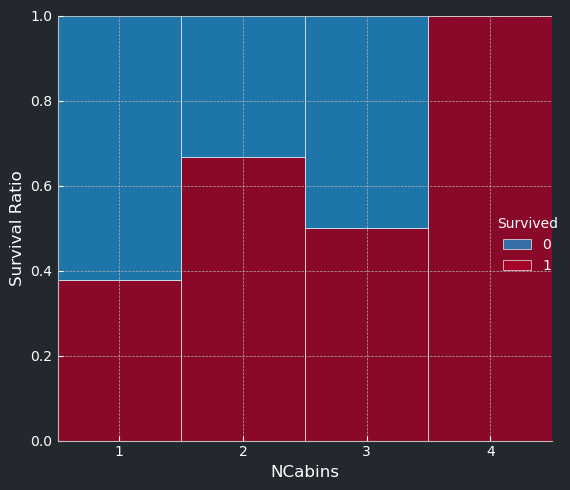

In [29]:
sns.displot(train_data, x="NCabins", hue="Survived", multiple="fill", discrete=True)
plt.ylabel("Survival Ratio")
plt.gca().xaxis.set_major_locator(mplticker.MultipleLocator(1))

In [30]:
# joint_data().groupby("Cabin", as_index=False).Ticket.nunique()[
#     joint_data()
#     .groupby("Cabin", as_index=False)
#     .Ticket.count()["Cabin"]
#     .map(lambda x: len(x.split()), na_action="ignore")
#     > 1
# ]

The first letter of each cabin code corresponds to the deck level where the cabin is located. `Deck` is extracted from the `Cabin` and the missing values simply encoded as "M". This way the missing values can be dealt with as a separate category of the `Deck` feature by the final model.

In [31]:
for data in [train_data, test_data]:
    data["Cabin"].fillna("M", inplace=True)
    data["Cabin"] = data.Cabin.apply(lambda x: x[0])
    data.rename(columns={"Cabin": "Deck"}, inplace=True)

joint_data().Deck.value_counts()

M    1014
C      94
B      65
D      46
E      44
A      22
F      14
G       9
T       1
Name: Deck, dtype: int64

`Deck` is an ordinal categorical feature. A is the topmost deck, G is the lowest passenger deck, T is the lowest deck of a ship (where the engines and boiler rooms are).  
Passengers on the middle decks B through F had the highest survival rates, whereas those on the lowest passenger deck, and those whose cabin codes are missing, had the lowest success rate. The only passenger whose cabin was on the Tank Top deck (below the Orlop Deck) did not survive.

Text(30.000000000000014, 0.5, 'Survival Ratio')

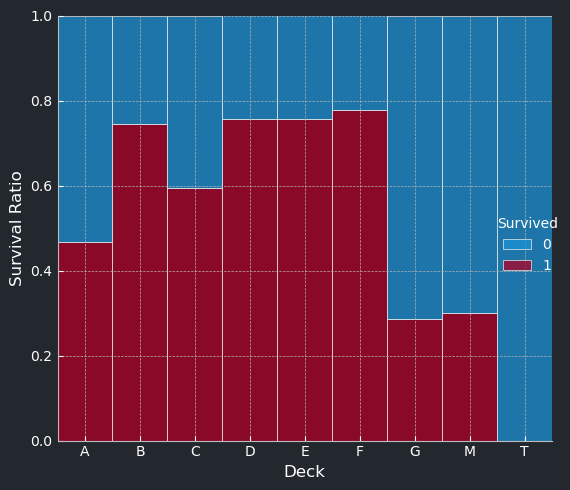

In [32]:
sns.displot(
    train_data.sort_values(by="Deck"), x="Deck", hue="Survived", multiple="fill"
)
plt.ylabel("Survival Ratio")

All missing values have been dealt with.

In [33]:
joint_data().isna().sum()

Survived         418
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Deck               0
Embarked           0
Complimentary      0
NCabins            0
dtype: int64

### Feature Engineering

`Family_Size` is created by adding `SibSp, Parch` and 1. Those who travel entirely alone don't seem to have had the highest chance of survival.

<Axes: xlabel='Family_Size', ylabel='count'>

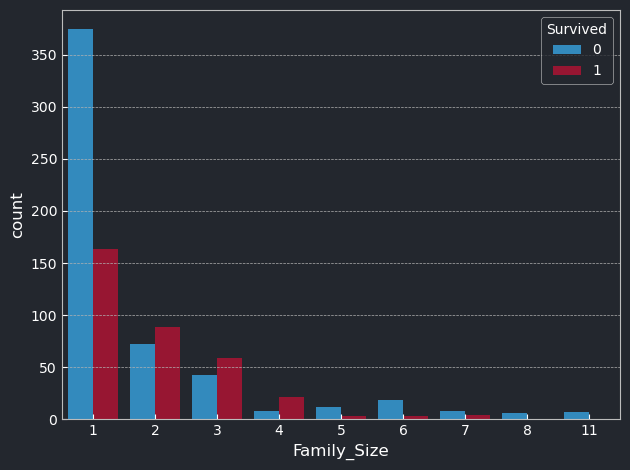

In [34]:
for data in [train_data, test_data]:
    data["Family_Size"] = data.SibSp + data.Parch + 1

sns.countplot(train_data, x="Family_Size", hue="Survived")

`Ticket_Freq` is created by encoding the frequency with which a ticket occurs, which gives an idea of the size of the group in which one was traveling.

<Axes: xlabel='Ticket_Freq', ylabel='count'>

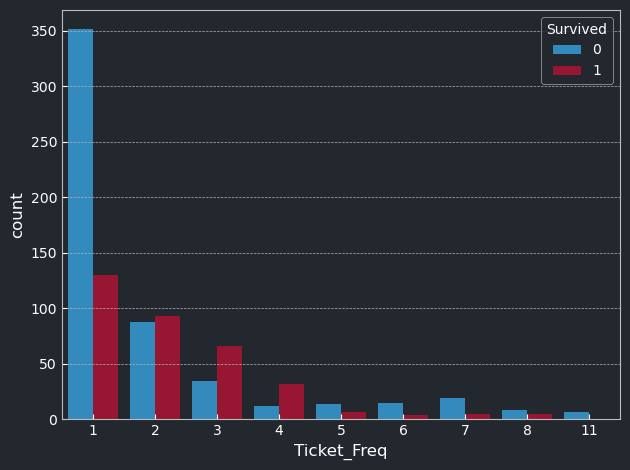

In [35]:
train_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[:891]
)
test_data["Ticket_Freq"] = (
    joint_data().groupby("Ticket")["Ticket"].transform("count")[891:]
)

sns.countplot(train_data, x="Ticket_Freq", hue="Survived")

In a similar manner, `Surname_Freq` is created. First the surname is extracted from the name, and then the frequency with which a surname occurs is encoded.

<Axes: xlabel='Surname_Freq', ylabel='count'>

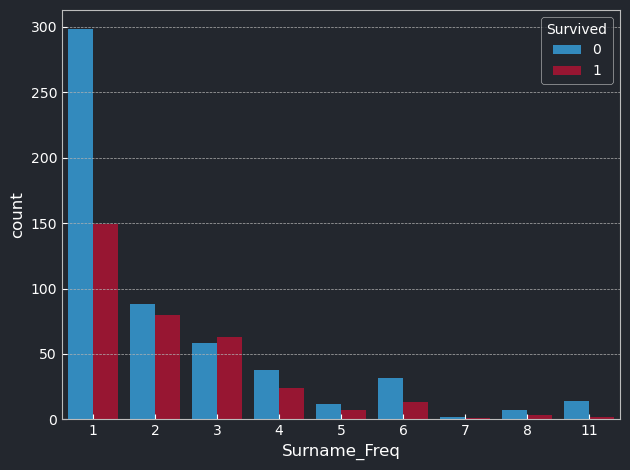

In [36]:
def extract_surname(name):
    if "(" in name:
        name_no_bracket = name.split("(")[0]
    else:
        name_no_bracket = name
    family = name_no_bracket.split(",")[0]
    return family


for data in [train_data, test_data]:
    data["Name"] = data.Name.apply(extract_surname)

train_data["Surname_Freq"] = (
    joint_data().groupby("Name")["Name"].transform("count")[:891]
)
test_data["Surname_Freq"] = (
    joint_data().groupby("Name")["Name"].transform("count")[891:]
)

sns.countplot(train_data, x="Surname_Freq", hue="Survived")

`Name` and `Ticket` are dropped as they are no longer needed and contain no useful information.

In [37]:
for data in [train_data, test_data]:
    data.drop(columns=["Name", "Ticket"], inplace=True)

`Fare` is transformed to log scale to deal with right skewness.

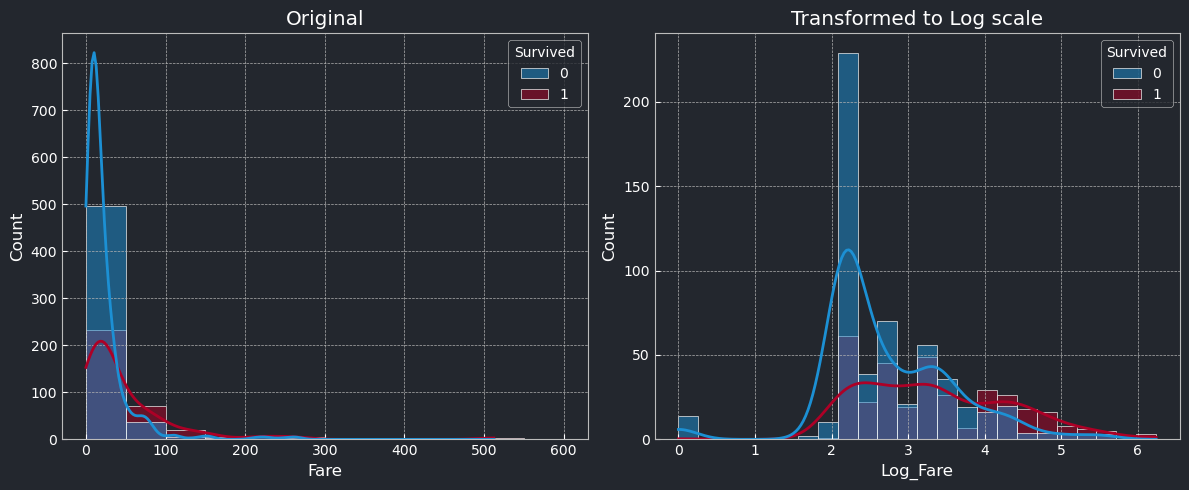

In [38]:
for data in [train_data, test_data]:
    data["Log_Fare"] = np.log1p(data["Fare"])

_, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(
    train_data,
    x="Fare",
    hue="Survived",
    binwidth=50,
    binrange=(0, 600),
    kde=True,
    ax=axs[0],
)
sns.histplot(
    train_data,
    x="Log_Fare",
    hue="Survived",
    kde=True,
    ax=axs[1],
)
axs[0].set_title("Original")
axs[1].set_title("Transformed to Log scale")

for data in [train_data, test_data]:
    data.drop(columns="Fare", inplace=True)

The ratio between the price and quantity could prove to be a useful feature, so it is created by dividing the `Log_Fare` by `Ticket_Freq`.

<Axes: xlabel='Log_Fare/Ticket_Freq', ylabel='Count'>

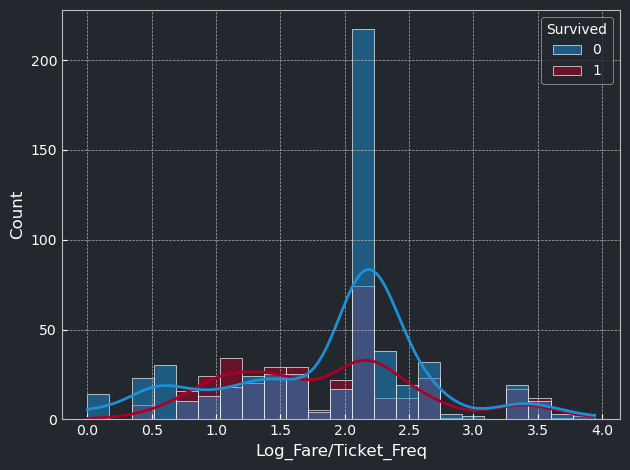

In [39]:
for data in [train_data, test_data]:
    data["Log_Fare/Ticket_Freq"] = data["Log_Fare"] / data["Ticket_Freq"]

sns.histplot(
    train_data,
    x="Log_Fare/Ticket_Freq",
    hue="Survived",
    kde=True,
)

##### Encoding

Nominal: `Survived, Sex, Deck, Embarked, Complimentary`  
Ordinal: `Pclass`  
Continuous: `Age, Log_Fare, Log_Fare/Ticket_Freq`  
Discrete: `SibSp, Parch, NCabins, Family_Size, Ticket_Freq, Surname_Freq` 

In [40]:
# Might come in handy
nominal = ["Survived", "Sex", "Deck", "Embarked", "Complimentary"]
ordinal = ["Pclass"]
continuous = ["Age", "Log_Fare", "Log_Fare/Ticket_Freq"]
discrete = ["SibSp", "Parch", "NCabins", "Family_Size", "Ticket_Freq", "Surname_Freq"]

In [41]:
joint_data().head()

Survived  Pclass     Sex   Age  SibSp  Parch Deck Embarked  Complimentary  \
0       0.0       3    male  22.0      1      0    M        S              0   
1       1.0       1  female  38.0      1      0    C        C              0   
2       1.0       3  female  26.0      0      0    M        S              0   
3       1.0       1  female  35.0      1      0    C        S              0   
4       0.0       3    male  35.0      0      0    M        S              0   

   NCabins  Family_Size  Ticket_Freq  Surname_Freq  Log_Fare  \
0      1.0            2            1             2  2.110213   
1      1.0            2            2             2  4.280593   
2      1.0            1            1             1  2.188856   
3      1.0            2            2             2  3.990834   
4      1.0            1            1             2  2.202765   

   Log_Fare/Ticket_Freq  
0              2.110213  
1              2.140297  
2              2.188856  
3              1.995417  
4              2.202765

All features except `Sex, Deck` and `Embarked` are already properly encoded, so only they are encoded (as a one-hot numeric array). Dummy variables include redundant information, so to overcome the Dummy variable Trap, one dummy per categorical variable is dropped. In the binary case, one column is dropped automatically by OneHotEncoder. The choice of which dummy variable to drop is arbitrary and doesn't affect the model's overall performance, so for interpretability purposes the dummy that represents the category with the lowest population is dropped. 

In [42]:
feat = ["Sex", "Deck", "Embarked"]
ord_enc = OneHotEncoder(drop="if_binary", sparse_output=False).set_output(
    transform="pandas"
)
train_data = train_data.drop(columns=feat).join(ord_enc.fit_transform(train_data[feat]))
test_data = test_data.drop(columns=feat).join(ord_enc.transform(test_data[feat]))
for data in [train_data, test_data]:
    data.drop(columns=["Deck_T", "Embarked_Q"], inplace=True)

joint_data().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Survived              891 non-null    float64
 1   Pclass                1309 non-null   int64  
 2   Age                   1309 non-null   float64
 3   SibSp                 1309 non-null   int64  
 4   Parch                 1309 non-null   int64  
 5   Complimentary         1309 non-null   int64  
 6   NCabins               1309 non-null   float64
 7   Family_Size           1309 non-null   int64  
 8   Ticket_Freq           1309 non-null   int64  
 9   Surname_Freq          1309 non-null   int64  
 10  Log_Fare              1309 non-null   float64
 11  Log_Fare/Ticket_Freq  1309 non-null   float64
 12  Sex_male              1309 non-null   float64
 13  Deck_A                1309 non-null   float64
 14  Deck_B                1309 non-null   float64
 15  Deck_C                

##### Dealing with Multicollinearity

In [43]:
class SelectCorrelationClusters(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        threshold=0.7,
        corr_method="spearman",
        linkage_method="ward",
        optimal_ordering=True,
    ):
        self.threshold = threshold
        self.corr_method = corr_method
        self.linkage_method = linkage_method
        self.optimal_ordering = optimal_ordering

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Remove constant columns and calculate correlation
        self.constant_cols = np.where(X.nunique() == 1)[0]
        self.corr_ = X.drop(columns=X.columns[self.constant_cols]).corr(
            method=self.corr_method
        )
        # Convert the correlation matrix to a distance matrix before performing hierarchical clustering
        distance_matrix = 1 - self.corr_.abs()
        self.Z = linkage(
            squareform(distance_matrix, checks=False),
            "ward",
            optimal_ordering=self.optimal_ordering,
        )
        # Extract the cluster labels for each feature based on the specified threshold
        clusters = fcluster(self.Z, self.threshold, criterion="distance")
        # Filter out highly correlated features
        # Keep one feature per cluster with the maximum average correlation
        self.kept_features = []
        for cluster_id in set(clusters):
            clusters_boolean = clusters == cluster_id
            corr_vals = self.corr_.iloc[clusters_boolean, clusters_boolean]
            best_feature_idx = corr_vals.abs().sum(axis=1).idxmax()
            self.kept_features.append(corr_vals.columns.get_loc(best_feature_idx))
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        return X.drop(columns=X.columns[self.constant_cols]).iloc[:, self.kept_features]

    def plot(self, annot=True, cmap="RdBu", split=True):
        if not split:
            # Plot clustermap
            sns.clustermap(
                self.corr_.round(2),
                row_linkage=self.Z,
                col_linkage=self.Z,
                cmap=cmap,
                annot=annot,
                annot_kws={"size": 8},
                vmin=-1,
                vmax=1,
                figsize=(15, 12),
                dendrogram_ratio=0.2,
            )
        else:
            # Plot dendrogram with correlation heatmap
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))
            dendro = dendrogram(
                self.Z,
                labels=self.corr_.columns,
                ax=ax1,
                leaf_rotation=90,
            )
            order = dendro["leaves"]
            sns.heatmap(
                self.corr_.iloc[order, order],
                cmap=cmap,
                annot=annot,
                vmin=-1,
                vmax=1,
                # linewidths=0.01,
                # linecolor="#23272e",
                ax=ax2,
            )
            fig.tight_layout()
        plt.show()


def calculate_vif(data):
    # Exclude the dependent variable from X
    X = data.drop("Survived", axis=1)

    # Add constant column
    # X = add_constant(X)
    X = X.assign(const=1)

    # Calculate VIF for each variable
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif


When a dummy variable that represents more than two categories has a high VIF, multicollinearity does not necessarily exist. The variables will always have high VIFs if there is a small portion of cases in the category, regardless of whether the categorical variables are correlated to other variables, so dummy encoded nominal variables are ignored.  
`Family_Size, SibSp` and `Parch` have an infinite VIF score and are perfectly multicollinear. They all have high correlation scores, along with `Surname_Freq` and `Ticket_Freq`. Considering their MI scores, `Family_Size` is kept and the rest are dropped, along with `Log_Fare`, which also has high correlation scores with those previously mentioned and with `Log_Fare/Ticket_Freq`, with the exception that it also has high correlation with `Pclass` (which the rest do not).

In [44]:
mutinf = pd.Series(
    mutual_info_classif(
        train_data.drop(columns="Survived"),
        train_data["Survived"],
        # discrete_features=[
        #     True
        #     if col
        #     not in [
        #         "Age",
        #         "Log_Fare",
        #         "Log_Fare/Ticket_Freq",
        #     ]
        #     else False
        #     for col in train_data.drop(columns="Survived").columns
        # ],
        discrete_features=True,
        random_state=seed,
    ),
    index=train_data.drop(columns="Survived").columns,
).sort_values(ascending=False)


Variable         VIF
0                 Pclass    8.160397
1                    Age    1.434965
2                  SibSp         inf
3                  Parch         inf
4          Complimentary    5.285754
5                NCabins    1.247472
6            Family_Size         inf
7            Ticket_Freq    8.562862
8           Surname_Freq    3.266213
9               Log_Fare   14.473798
10  Log_Fare/Ticket_Freq    4.913899
11              Sex_male    1.201721
12                Deck_A   15.789237
13                Deck_B   46.064876
14                Deck_C   56.542978
15                Deck_D   33.051960
16                Deck_E   33.072469
17                Deck_F   10.103933
18                Deck_G    8.163004
19                Deck_M  160.964898
20            Embarked_C    3.006689
21            Embarked_S    2.869515
22                 const    0.000000

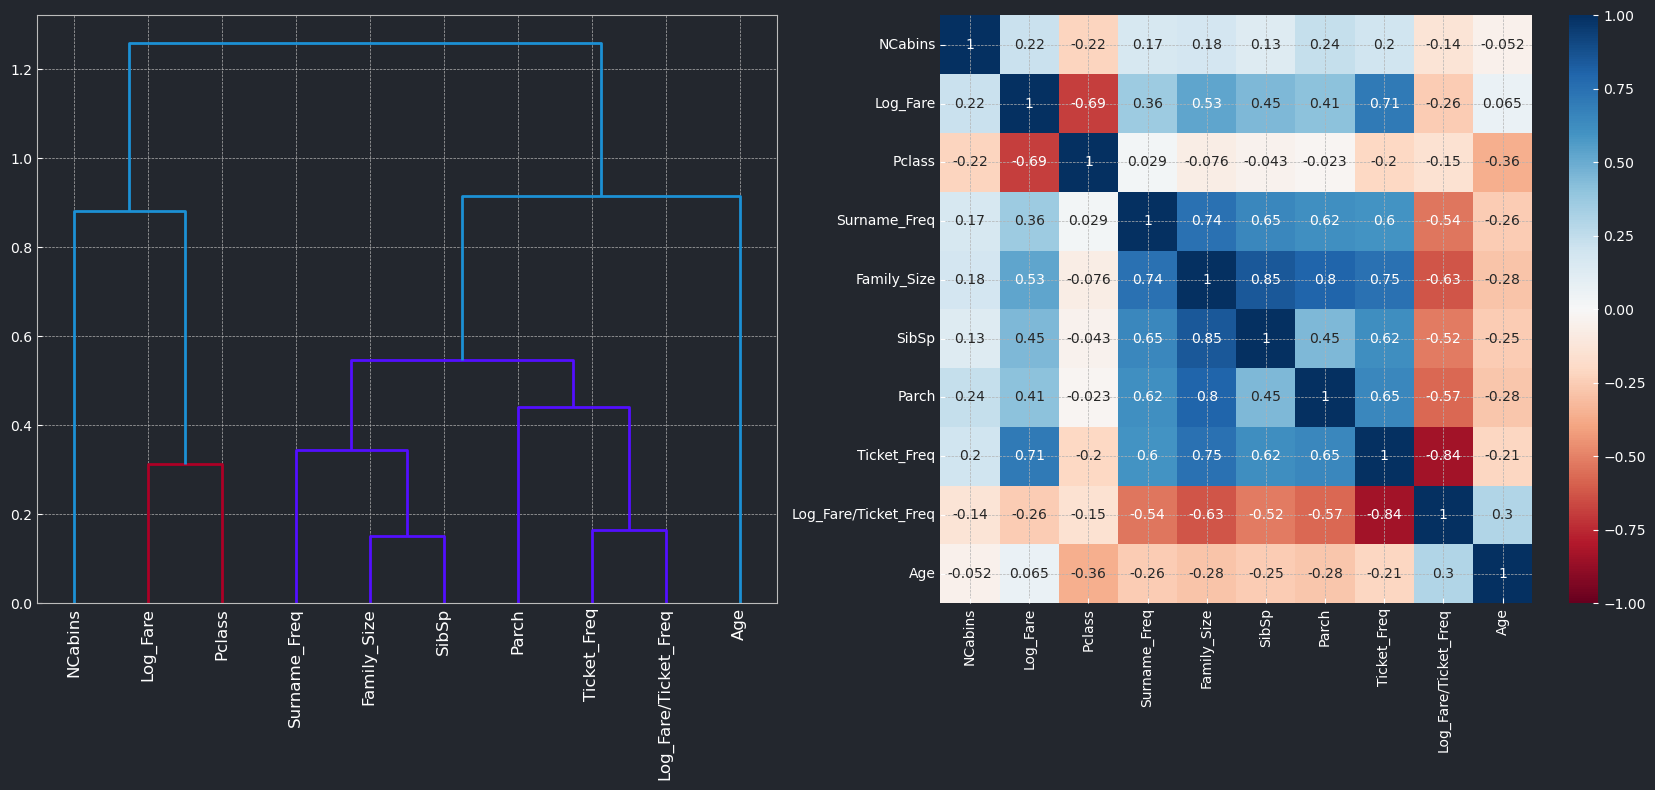

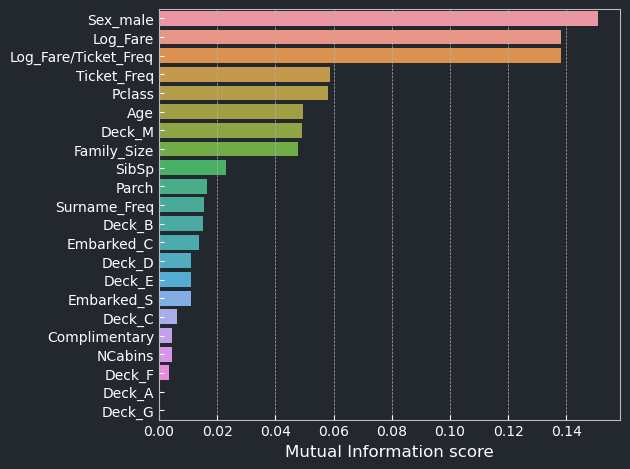

In [45]:
%%capture --no-display
display(calculate_vif(train_data))
SelectCorrelationClusters().fit(train_data[discrete + continuous + ordinal]).plot()
mutinf = pd.Series(
    mutual_info_classif(
        train_data.drop(columns="Survived"),
        train_data["Survived"],
        discrete_features=[
            True
            if col
            not in [
                "Age",
                "Log_Fare",
                "Log_Fare/Ticket_Freq",
            ]
            else False
            for col in train_data.drop(columns="Survived").columns
        ],
        # discrete_features=True,
        random_state=seed,
    ),
    index=train_data.drop(columns="Survived").columns,
).sort_values(ascending=False)
sns.barplot(x=mutinf, y=mutinf.index.astype(str))
plt.xlabel("Mutual Information score")
plt.tight_layout()
plt.show()

In [46]:
for data in [train_data, test_data]:
    data.drop(
        columns=[
            "SibSp",
            "Parch",
            "Surname_Freq",
            "Ticket_Freq",
            "Log_Fare",
        ],
        inplace=True,
    )
# Might come in handy
nominal = ["Survived", "Sex", "Deck", "Embarked", "Complimentary"]
ordinal = ["Pclass"]
continuous = ["Age", "Log_Fare/Ticket_Freq"]
discrete = ["NCabins", "Family_Size"]


Now all VIF scores are within reasonable bounds.

In [47]:
calculate_vif(train_data)


Variable          VIF
0                 Pclass     2.832796
1                    Age     1.402006
2          Complimentary     1.439344
3                NCabins     1.224549
4            Family_Size     1.919622
5   Log_Fare/Ticket_Freq     2.457839
6               Sex_male     1.159154
7                 Deck_A    15.770294
8                 Deck_B    45.993073
9                 Deck_C    56.468756
10                Deck_D    32.959773
11                Deck_E    32.956078
12                Deck_F    10.028784
13                Deck_G     8.117951
14                Deck_M   160.250185
15            Embarked_C     2.958180
16            Embarked_S     2.844321
17                 const  1012.747229

##### Reciprocal

Next the multiplicative inverse of ordinal/continuous/discrete features is added with the purpose of extracting ratios when 2nd degree polynomial interactions are applied.

In [48]:
train_data = train_data.join(
    1 / (train_data[ordinal + continuous + discrete] + 1), rsuffix="_inverted"
)
test_data = test_data.join(
    1 / (test_data[ordinal + continuous + discrete] + 1), rsuffix="_inverted"
)


### Model training and selection

In [49]:
# Prepare data
X = train_data.copy()
y = X.pop("Survived")
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

In [50]:
# Define score function to go into SelectPercentile
discrete_features = [
    True
    if col
    not in [
        "Age",
        "Log_Fare/Ticket_Freq",
        "Age_inverted",
        "Log_Fare/Ticket_Freq_inverted",
    ]
    else False
    for col in X.columns
]


def mut_info(X, y):
    return mutual_info_classif(
        X,
        y,
        discrete_features=discrete_features,
        random_state=seed,
    )


# Define transformer to clean up after adding feature interactions and standardizing
class RemoveDuplicates(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = pd.DataFrame(X)
        self.not_dup = list(df.columns[~df.T.duplicated()])
        return self

    def transform(self, X):
        df = pd.DataFrame(X)
        return df.loc[:, self.not_dup]  # .to_numpy()


# Define function to create a DataFrame from top scores
def get_top_scores(study):
    df = (
        study.trials_dataframe(attrs=("value", "duration", "params", "state"))
        .sort_values(by="value", ascending=False)
        .head(10)
    )
    df["duration"] = df["duration"].dt.total_seconds()
    return df


# Define function to calculate validation/test scores for top sets of hyperparameters
def model_val_score(model, study_name, top_scores, result_storage):
    res = []
    for i in range(len(top_scores) - 1, -1, -1):
        MI_percentile = top_scores.iloc[i].params_MI_percentile
        poly = top_scores.iloc[i].params_poly.astype(int)
        try:
            l1_C = top_scores.iloc[i].params_l1_C
            model_params = (
                top_scores.iloc[i]
                .drop(
                    [
                        "value",
                        "duration",
                        "state",
                        "params_MI_percentile",
                        "params_poly",
                        "params_l1_C",
                    ]
                )
                .rename(lambda x: x[7:])
                .to_dict()
            )
            model.set_params(**model_params)
            pipe = make_pipeline(
                SelectPercentile(mut_info, percentile=MI_percentile),
                PolynomialFeatures(
                    degree=poly,
                    interaction_only=True,
                    include_bias=False,
                ),
                standardize,
                cleanup,
                SelectFromModel(
                    LinearSVC(
                        C=l1_C,
                        penalty="l1",
                        dual=False,
                        max_iter=100000,
                    )
                ),
                model,
            )
        except:
            model_params = (
                top_scores.iloc[i]
                .drop(
                    [
                        "value",
                        "duration",
                        "state",
                        "params_MI_percentile",
                        "params_poly",
                    ]
                )
                .rename(lambda x: x[7:])
                .to_dict()
            )
            model.set_params(**model_params)
            pipe = make_pipeline(
                SelectPercentile(mut_info, percentile=MI_percentile),
                PolynomialFeatures(
                    degree=poly,
                    interaction_only=True,
                    include_bias=False,
                ),
                standardize,
                cleanup,
                model,
            )
        res.append(pipe.fit(X_train, y_train).score(X_val, y_val))
    result_storage.loc[study_name] = res[::-1]
    display(result_storage.loc[study_name])


# Define function to generate submissions
def submissions_from_model(model, study_name, top_scores, n_submissions=1):
    for sub_num, i in enumerate(
        range(len(top_scores) - 1, len(top_scores) - n_submissions - 1, -1), 1
    ):
        MI_percentile = top_scores.iloc[i].params_MI_percentile
        poly = top_scores.iloc[i].params_poly.astype(int)
        l1_C = top_scores.iloc[i].params_l1_C
        try:
            model_params = (
                top_scores.iloc[i]
                .drop(
                    [
                        "value",
                        "duration",
                        "state",
                        "params_MI_percentile",
                        "params_poly",
                        "params_l1_C",
                    ]
                )
                .rename(lambda x: x[7:])
                .to_dict()
            )
        except:
            model_params = (
                top_scores.iloc[i]
                .drop(
                    [
                        "value",
                        "duration",
                        "state",
                        "params_MI_percentile",
                        "params_poly",
                    ]
                )
                .rename(lambda x: x[7:])
                .to_dict()
            )
        model.set_params(**model_params)
        pipe = make_pipeline(
            SelectPercentile(mut_info, percentile=MI_percentile),
            PolynomialFeatures(
                degree=poly,
                interaction_only=True,
                include_bias=False,
            ),
            standardize,
            cleanup,
            SelectFromModel(
                LinearSVC(
                    C=l1_C,
                    penalty="l1",
                    dual=False,
                    max_iter=100000,
                )
            ),
            model,
        )
        predictions = pipe.fit(X, y).predict(test_data)
        predictions_df = pd.DataFrame(
            {"PassengerId": PassengerId, "Survived": predictions}
        )
        predictions_df.to_csv(
            f"{study_name}_submission_{sub_num}.csv", header=True, index=False
        )


In [51]:
# Initiate pipeline steps
standardize = StandardScaler()
cleanup = RemoveDuplicates()

# Define DB file name for storing tuning results
db_name = "titanic_study"
storage_name = f"sqlite:///{db_name}.db"

# Create DataFrame to store results of model evaluations
model_results = pd.DataFrame(columns=[f"param_set_{i}" for i in range(1, 11)])

##### Logistic Regression

In [52]:
rng = np.random.RandomState(seed)
# Initiate estimator
model = LogisticRegression(
    max_iter=100000,
    n_jobs=-1,
    random_state=rng,
)


# Define the objective of the study
def objective(trial):
    # Set estimator parameters
    model.set_params(
        C=trial.suggest_float("C", 1e-4, 1000, log=True),
        solver=trial.suggest_categorical(
            "solver", ["liblinear", "lbfgs", "newton-cg", "sag", "saga"]
        ),
    )
    # Create Pipeline
    pipe = make_pipeline(
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        standardize,
        cleanup,
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_C", 1e-2, 10, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
                random_state=seed,
            )
        ),
        model,
    )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score


In [53]:
# Define unique identifier of the study
study_name = "Logistic_Regression"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

[I 2023-07-03 10:08:38,468] A new study created in RDB with name: Logistic_Regression


Sampler: TPESampler


In [54]:
# Perform hyperparameter optimization search
study.optimize(objective, n_trials=90)

[I 2023-07-03 10:08:40,160] Trial 0 finished with value: 0.7693459293201933 and parameters: {'C': 0.041858227295469716, 'MI_percentile': 6, 'l1_C': 1.3311216080736887, 'poly': 1, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7693459293201933.
[I 2023-07-03 10:08:40,984] Trial 1 finished with value: 0.7699391124223213 and parameters: {'C': 0.000139345022513376, 'MI_percentile': 31, 'l1_C': 0.07476312062252301, 'poly': 1, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7699391124223213.
[I 2023-07-03 10:08:41,296] Trial 2 finished with value: 0.787882116627958 and parameters: {'C': 1.918537370384187, 'MI_percentile': 20, 'l1_C': 0.013783237455007183, 'poly': 2, 'solver': 'saga'}. Best is trial 2 with value: 0.787882116627958.
[I 2023-07-03 10:08:41,757] Trial 3 finished with value: 0.810344611135522 and parameters: {'C': 1.7898389848671583, 'MI_percentile': 31, 'l1_C': 0.2091498132903561, 'poly': 2, 'solver': 'sag'}. Best is trial 3 with value: 0.810344611135522.
[I 2023-07

In [55]:
top_scores = get_top_scores(study)
top_scores

value  duration  params_C  params_MI_percentile  params_l1_C  \
20  0.824364  0.358431  0.389790                    43     0.115375   
84  0.824364  0.327440  0.360241                    44     0.111689   
77  0.823803  0.360032  0.590439                    44     0.135137   
32  0.822692  0.308735  0.661202                    47     0.089229   
70  0.821568  0.298120  0.604254                    46     0.082881   

    params_poly params_solver     state  
20            2          saga  COMPLETE  
84            2         lbfgs  COMPLETE  
77            2         lbfgs  COMPLETE  
32            2         lbfgs  COMPLETE  
70            2         lbfgs  COMPLETE

In [56]:
model_val_score(model, study_name, top_scores, model_results)

param_set_1    0.815642
param_set_2    0.815642
param_set_3    0.815642
param_set_4    0.804469
param_set_5    0.804469
Name: Logistic_Regression, dtype: float64

In [57]:
# submissions_from_model(model, study_name, top_scores)

In [58]:
optuna.visualization.plot_optimization_history(study)


In [59]:
optuna.visualization.plot_slice(study)


In [60]:
optuna.visualization.plot_edf(study)


##### K-Nearest Neighbours

In [63]:
rng = np.random.RandomState(seed)
# Initiate estimator
model = KNeighborsClassifier(
    n_jobs=-1,
)


# Define the objective of the study
def objective(trial):
    # Set estimator parameters
    model.set_params(n_neighbors=trial.suggest_int("n_neighbors", 4, 40))
    # Create Pipeline
    pipe = make_pipeline(
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        standardize,
        cleanup,
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_C", 1e-2, 10, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
                random_state=seed,
            )
        ),
        model,
    )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score


In [64]:
# Define unique identifier of the study
study_name = "K-Nearest_Neighbors"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

[I 2023-07-03 10:09:25,876] A new study created in RDB with name: K-Nearest_Neighbors


Sampler: TPESampler


In [65]:
# Perform hyperparameter optimization search
study.optimize(objective, n_trials=90)

[I 2023-07-03 10:09:26,225] Trial 0 finished with value: 0.8030286862092775 and parameters: {'MI_percentile': 96, 'l1_C': 0.02938027938703535, 'n_neighbors': 17, 'poly': 1}. Best is trial 0 with value: 0.8030286862092775.
[I 2023-07-03 10:09:26,702] Trial 1 finished with value: 0.7833751804657585 and parameters: {'MI_percentile': 6, 'l1_C': 1.3311216080736887, 'n_neighbors': 9, 'poly': 1}. Best is trial 0 with value: 0.8030286862092775.
[I 2023-07-03 10:09:27,068] Trial 2 finished with value: 0.8013558470905782 and parameters: {'MI_percentile': 97, 'l1_C': 0.035113563139704075, 'n_neighbors': 4, 'poly': 1}. Best is trial 0 with value: 0.8030286862092775.
[I 2023-07-03 10:09:27,394] Trial 3 finished with value: 0.816518109346557 and parameters: {'MI_percentile': 31, 'l1_C': 0.07476312062252301, 'n_neighbors': 10, 'poly': 1}. Best is trial 3 with value: 0.816518109346557.
[I 2023-07-03 10:09:27,730] Trial 4 finished with value: 0.8058533676479819 and parameters: {'MI_percentile': 14, 'l1

In [66]:
top_scores = get_top_scores(study)
top_scores

value  duration  params_MI_percentile  params_l1_C  params_n_neighbors  \
31  0.823809  0.277086                    41     0.104641                  10   
23  0.823247  0.262002                    40     0.077930                  10   
32  0.821577  0.268128                    39     0.342453                  10   
85  0.821009  0.267311                    40     0.159105                  12   
88  0.820444  0.316216                    39     0.096611                  13   

    params_poly     state  
31            1  COMPLETE  
23            1  COMPLETE  
32            1  COMPLETE  
85            1  COMPLETE  
88            1  COMPLETE

In [67]:
model_val_score(model, study_name, top_scores, model_results)

param_set_1    0.815642
param_set_2    0.815642
param_set_3    0.804469
param_set_4    0.821229
param_set_5    0.826816
Name: K-Nearest_Neighbors, dtype: float64

In [68]:
# submissions_from_model(model, study_name, top_scores)

In [69]:
optuna.visualization.plot_optimization_history(study)


In [70]:
optuna.visualization.plot_slice(study)


In [71]:
optuna.visualization.plot_edf(study)


##### Random Forrest

In [74]:
rng = np.random.RandomState(seed)
# Initiate estimator
model = RandomForestClassifier(n_jobs=-1, random_state=rng)


# Define the objective of the study
def objective(trial):
    # Set estimator parameters
    model.set_params(
        max_depth=trial.suggest_int("max_depth", 5, 50),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 3, 150),
        max_features=trial.suggest_float("max_features", 0.2, 0.8),
        ccp_alpha=trial.suggest_float("ccp_alpha", 1e-9, 0.1),
    )
    # Create Pipeline
    pipe = make_pipeline(
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        standardize,
        cleanup,
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_C", 1e-5, 10, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
                random_state=seed,
            )
        ),
        model,
    )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score


In [75]:
# Define unique identifier of the study
study_name = "Random_Forrest"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

[I 2023-07-03 10:10:01,057] A new study created in RDB with name: Random_Forrest


Sampler: TPESampler


In [76]:
# Perform hyperparameter optimization search
study.optimize(objective, n_trials=90)

[I 2023-07-03 10:10:01,724] Trial 0 finished with value: 0.786761659657272 and parameters: {'MI_percentile': 16, 'ccp_alpha': 0.059865888553855245, 'l1_C': 3.9676050770529883, 'max_depth': 22, 'max_features': 0.685595153449124, 'min_samples_leaf': 143, 'poly': 1}. Best is trial 0 with value: 0.786761659657272.
[I 2023-07-03 10:10:02,410] Trial 1 finished with value: 0.6161822861088445 and parameters: {'MI_percentile': 84, 'ccp_alpha': 0.09699098822521422, 'l1_C': 0.03549878832196503, 'max_depth': 32, 'max_features': 0.11646759543664197, 'min_samples_leaf': 107, 'poly': 1}. Best is trial 0 with value: 0.786761659657272.
[I 2023-07-03 10:10:03,169] Trial 2 finished with value: 0.786761659657272 and parameters: {'MI_percentile': 62, 'ccp_alpha': 0.02912298489689017, 'l1_C': 0.1256277350380703, 'max_depth': 18, 'max_features': 0.4455560149136927, 'min_samples_leaf': 80, 'poly': 2}. Best is trial 0 with value: 0.786761659657272.
[I 2023-07-03 10:10:03,759] Trial 3 finished with value: 0.786

In [77]:
top_scores = get_top_scores(study)
top_scores

value  duration  params_MI_percentile  params_ccp_alpha  params_l1_C  \
68  0.828303  0.876234                    69          0.000065     0.021652   
84  0.826608  0.678523                    74          0.007577     0.010298   
66  0.826059  0.739964                    66          0.003354     0.023457   
42  0.826040  0.996872                    76          0.004098     0.014711   
54  0.826040  0.710439                    58          0.000710     0.012712   

    params_max_depth  params_max_features  params_min_samples_leaf  \
68                33             0.534593                        7   
84                48             0.490860                        3   
66                44             0.550139                        3   
42                48             0.706017                       12   
54                47             0.470916                       10   

    params_poly     state  
68            2  COMPLETE  
84            2  COMPLETE  
66            2  COMPLETE  
42            2  COMPLETE  
54            2  COMPLETE

In [78]:
model_val_score(model, study_name, top_scores, model_results)

param_set_1    0.804469
param_set_2    0.821229
param_set_3    0.810056
param_set_4    0.815642
param_set_5    0.810056
Name: Random_Forrest, dtype: float64

In [79]:
# submissions_from_model(model, study_name, top_scores)

In [80]:
optuna.visualization.plot_optimization_history(study)


In [81]:
optuna.visualization.plot_slice(study)


In [82]:
optuna.visualization.plot_edf(study)


In [83]:
optuna.visualization.plot_param_importances(study)


In [84]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)


##### Support Vector Machine

In [85]:
rng = np.random.RandomState(seed)
# Initiate estimator
model = SVC(gamma="scale", max_iter=100000, random_state=rng, cache_size=1000)


# Define the objective of the study
def objective(trial):
    # Set estimator parameters
    model.set_params(
        C=trial.suggest_float("C", 1e-4, 1000, log=True),
        kernel=trial.suggest_categorical("kernel", ["linear", "rbf", "sigmoid"]),
    )
    # Create Pipeline
    pipe = make_pipeline(
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 80)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        standardize,
        cleanup,
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_C", 1e-2, 20, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
                random_state=seed,
            )
        ),
        model,
    )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score


In [86]:
# Define unique identifier of the study
study_name = "Support Vector Machine"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

[I 2023-07-03 10:11:16,789] A new study created in RDB with name: Support Vector Machine


Sampler: TPESampler


In [87]:
# Perform hyperparameter optimization search
study.optimize(objective, n_trials=90)

[I 2023-07-03 10:11:17,169] Trial 0 finished with value: 0.7693459293201933 and parameters: {'C': 0.041858227295469716, 'MI_percentile': 6, 'gamma': 'scale', 'kernel': 'linear', 'l1_C': 2.1745470981373622, 'poly': 1}. Best is trial 0 with value: 0.7693459293201933.
[I 2023-07-03 10:11:17,479] Trial 1 finished with value: 0.6161822861088445 and parameters: {'C': 0.000139345022513376, 'MI_percentile': 31, 'gamma': 'auto', 'kernel': 'linear', 'l1_C': 0.0914863134229004, 'poly': 1}. Best is trial 0 with value: 0.7693459293201933.
[I 2023-07-03 10:11:17,794] Trial 2 finished with value: 0.6475676354277823 and parameters: {'C': 1.918537370384187, 'MI_percentile': 20, 'gamma': 'auto', 'kernel': 'sigmoid', 'l1_C': 0.014234237430895474, 'poly': 2}. Best is trial 0 with value: 0.7693459293201933.
[I 2023-07-03 10:11:18,333] Trial 3 finished with value: 0.7193930073441718 and parameters: {'C': 1.7898389848671583, 'MI_percentile': 31, 'gamma': 'scale', 'kernel': 'sigmoid', 'l1_C': 0.28376353418686

In [88]:
top_scores = get_top_scores(study)
top_scores

value  duration   params_C  params_MI_percentile params_gamma  \
89  0.825510  2.776604  86.104360                    32        scale   
59  0.825491  6.865794  23.341940                    36        scale   
71  0.825488  6.535966  26.397327                    40        scale   
58  0.824371  8.437922  24.235423                    36        scale   
75  0.823263  4.559924  89.503105                    31        scale   

   params_kernel  params_l1_C  params_poly     state  
89           rbf     3.765570            2  COMPLETE  
59           rbf    10.183650            2  COMPLETE  
71           rbf     7.580501            2  COMPLETE  
58           rbf    11.211531            2  COMPLETE  
75           rbf    16.671036            2  COMPLETE

In [89]:
model_val_score(model, study_name, top_scores, model_results)

param_set_1    0.815642
param_set_2    0.815642
param_set_3    0.815642
param_set_4    0.815642
param_set_5    0.815642
Name: Support Vector Machine, dtype: float64

In [90]:
# submissions_from_model(model, study_name, top_scores)

In [91]:
optuna.visualization.plot_optimization_history(study)


In [92]:
optuna.visualization.plot_slice(study)


In [93]:
optuna.visualization.plot_edf(study)


In [94]:
optuna.visualization.plot_param_importances(study)


In [95]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)


##### AdaBoost

In [96]:
rng = np.random.RandomState(seed)
# Initiate estimator
model = AdaBoostClassifier(random_state=rng)
from sklearn.tree import DecisionTreeClassifier


# Define the objective of the study
def objective(trial):
    # Set estimator parameters
    model.set_params(
        estimator=DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 1, 3)
        ),
        n_estimators=trial.suggest_int("n_estimators", 10, 100),
        learning_rate=trial.suggest_float("learning_rate", 1e-7, 1, log=True),
    )
    # Create Pipeline
    pipe = make_pipeline(
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        standardize,
        cleanup,
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_C", 1e-2, 10, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
                random_state=seed,
            )
        ),
        model,
    )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score

In [97]:
# Define unique identifier of the study
study_name = "AdaBoost"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

[I 2023-07-03 10:16:52,868] A new study created in RDB with name: AdaBoost


Sampler: TPESampler


In [98]:
# Perform hyperparameter optimization search
study.optimize(objective, n_trials=90)

[I 2023-07-03 10:16:53,519] Trial 0 finished with value: 0.803606176636746 and parameters: {'MI_percentile': 74, 'l1_C': 0.029375384576328288, 'learning_rate': 0.4518560951024106, 'n_estimators': 44, 'poly': 1}. Best is trial 0 with value: 0.803606176636746.
[I 2023-07-03 10:16:53,908] Trial 1 finished with value: 0.786761659657272 and parameters: {'MI_percentile': 61, 'l1_C': 8.123245085588687, 'learning_rate': 0.11567327199145977, 'n_estimators': 15, 'poly': 1}. Best is trial 0 with value: 0.803606176636746.
[I 2023-07-03 10:16:54,570] Trial 2 finished with value: 0.7800389178331555 and parameters: {'MI_percentile': 19, 'l1_C': 0.3752055855124282, 'learning_rate': 3.064599841241146e-06, 'n_estimators': 85, 'poly': 2}. Best is trial 0 with value: 0.803606176636746.
[I 2023-07-03 10:16:55,151] Trial 3 finished with value: 0.7895580942815894 and parameters: {'MI_percentile': 62, 'l1_C': 0.1256277350380703, 'learning_rate': 1.0929592787219391e-05, 'n_estimators': 49, 'poly': 2}. Best is 

In [99]:
top_scores = get_top_scores(study)
top_scores

value  duration  params_MI_percentile  params_l1_C  \
84  0.834467  0.451013                    91     0.018629   
60  0.834467  0.467870                    89     0.028007   
59  0.834467  0.520770                    88     0.027945   
81  0.833912  0.416275                    86     0.031745   
63  0.833906  0.436218                    95     0.025459   

    params_learning_rate  params_n_estimators  params_poly     state  
84              0.177243                   31            2  COMPLETE  
60              0.168628                   34            2  COMPLETE  
59              0.151273                   34            2  COMPLETE  
81              0.215566                   36            2  COMPLETE  
63              0.176165                   25            2  COMPLETE

In [100]:
model_val_score(model, study_name, top_scores, model_results)

param_set_1    0.821229
param_set_2    0.821229
param_set_3    0.821229
param_set_4    0.810056
param_set_5    0.821229
Name: AdaBoost, dtype: float64

In [101]:
# submissions_from_model(model, study_name, top_scores)

In [102]:
optuna.visualization.plot_optimization_history(study)


In [103]:
optuna.visualization.plot_slice(study)


In [104]:
optuna.visualization.plot_edf(study)


In [105]:
optuna.visualization.plot_param_importances(study)


In [106]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)


##### Gradient Boosting

In [107]:
rng = np.random.RandomState(seed)
# Initiate estimator
model = GradientBoostingClassifier(
    random_state=rng,
)


# Define the objective of the study
def objective(trial):
    # Set estimator parameters
    model.set_params(
        n_estimators=trial.suggest_int("n_estimators", 30, 400),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1, log=True),
        subsample=trial.suggest_float("subsample", 0.1, 1),
        min_samples_split=trial.suggest_float("min_samples_leaf", 1e-3, 1e-1, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 30),
        max_features=trial.suggest_float("max_features", 0.1, 0.9),
        ccp_alpha=trial.suggest_float("ccp_alpha", 1e-9, 0.1),
    )
    # Create Pipeline
    pipe = make_pipeline(
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        standardize,
        cleanup,
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_C", 1e-2, 10, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
                random_state=seed,
            )
        ),
        model,
    )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score

In [108]:
# Define unique identifier of the study
study_name = "Gradient Boosting"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

[I 2023-07-03 10:18:21,100] A new study created in RDB with name: Gradient Boosting


Sampler: TPESampler


In [109]:
# Perform hyperparameter optimization search
study.optimize(objective, n_trials=90)

[I 2023-07-03 10:18:21,798] Trial 0 finished with value: 0.8170736300295023 and parameters: {'MI_percentile': 87, 'ccp_alpha': 0.00580845540845873, 'l1_C': 0.011527987128232402, 'learning_rate': 0.6351221010640696, 'max_depth': 6, 'max_features': 0.22479561626896213, 'min_samples_leaf': 0.015751320499779727, 'n_estimators': 168, 'poly': 2, 'subsample': 0.7587945476302645}. Best is trial 0 with value: 0.8170736300295023.
[I 2023-07-03 10:18:22,700] Trial 1 finished with value: 0.7884407758458353 and parameters: {'MI_percentile': 44, 'ccp_alpha': 0.05247569068758062, 'l1_C': 0.02621087878265441, 'learning_rate': 0.21368329072358744, 'max_depth': 7, 'max_features': 0.3433937943676302, 'min_samples_leaf': 0.0023102018878452934, 'n_estimators': 389, 'poly': 2, 'subsample': 0.29110519961044856}. Best is trial 0 with value: 0.8170736300295023.
[W 2023-07-03 10:18:23,218] Trial 2 failed with parameters: {'MI_percentile': 5, 'ccp_alpha': 0.059241497644747364, 'l1_C': 0.015673095467235415, 'lear

In [110]:
top_scores = get_top_scores(study)
top_scores

value   duration  params_MI_percentile  params_ccp_alpha  params_l1_C  \
81  0.833909  20.675282                    58          0.002972     5.296845   
79  0.831671  23.521462                    67          0.001120     4.566704   
56  0.831109  37.327074                    80          0.004885     6.997192   
85  0.831097  17.888267                    51          0.001496     7.092570   
44  0.830544  36.259905                    94          0.005012     4.171295   

    params_learning_rate  params_max_depth  params_max_features  \
81              0.011983                29             0.385621   
79              0.023836                30             0.379261   
56              0.110728                19             0.231261   
85              0.008469                30             0.401198   
44              0.224766                14             0.405325   

    params_min_samples_leaf  params_n_estimators  params_poly  \
81                 0.001734                  250            2   
79                 0.001737                  282            2   
56                 0.002130                  341            2   
85                 0.002507                  255            2   
44                 0.003530                  188            2   

    params_subsample     state  
81          0.514431  COMPLETE  
79          0.422845  COMPLETE  
56          0.360293  COMPLETE  
85          0.549466  COMPLETE  
44          0.376570  COMPLETE

In [111]:
model_val_score(model, study_name, top_scores, model_results)

param_set_1    0.826816
param_set_2    0.815642
param_set_3    0.815642
param_set_4    0.826816
param_set_5    0.798883
Name: Gradient Boosting, dtype: float64

In [112]:
# submissions_from_model(model, study_name, top_scores)

In [113]:
optuna.visualization.plot_optimization_history(study)


In [114]:
optuna.visualization.plot_slice(study)


In [115]:
optuna.visualization.plot_edf(study)


In [116]:
optuna.visualization.plot_param_importances(study)


In [117]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)


##### XGBoost

In [118]:
rng = np.random.RandomState(seed)
# Initiate estimator
model = XGBClassifier(booster="gbtree", random_state=rng, verbosity=0)


# Define the objective of the study
def objective(trial):
    # Set estimator parameters
    model.set_params(
        n_estimators=trial.suggest_int("n_estimators", 30, 500),
        eta=trial.suggest_float("eta", 1e-4, 3, log=True),
        subsample=trial.suggest_float("subsmaple", 0.1, 1),
        max_depth=trial.suggest_int("max_depth", 2, 30),
        min_child_weight=trial.suggest_float("min_child_weight", 0, 50),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1),
        scale_pos_weight=trial.suggest_float("scale_pos_weight", 1e-4, 2),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 10),
    )
    # Create Pipeline
    pipe = make_pipeline(
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        standardize,
        cleanup,
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_C", 1e-3, 3, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
                random_state=seed,
            )
        ),
        model,
    )
    # Calculate scoring metric
    cv_score = cross_val_score(
        pipe,
        X,
        y,
        cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed),
        n_jobs=-1,
    ).mean()
    return cv_score

In [119]:
# Define unique identifier of the study
study_name = "XGBoost"

study = optuna.create_study(
    storage=storage_name,
    study_name=study_name,
    sampler=optuna.samplers.TPESampler(seed=seed),
    direction="maximize",
    load_if_exists=True,
)
print(f"Sampler: {study.sampler.__class__.__name__}")

[I 2023-07-03 10:46:56,949] A new study created in RDB with name: XGBoost


Sampler: TPESampler


In [120]:
# Perform hyperparameter optimization search
study.optimize(objective, n_trials=100)

[I 2023-07-03 10:47:06,197] Trial 0 finished with value: 0.6161822861088445 and parameters: {'MI_percentile': 71, 'colsample_bytree': 0.5779972601681014, 'eta': 1.8049419066778858, 'l1_C': 2.1368329072358767, 'max_depth': 19, 'min_child_weight': 7.800932022121826, 'n_estimators': 206, 'poly': 2, 'reg_alpha': 6.011190005930914, 'reg_lambda': 8.661774840134774, 'scale_pos_weight': 0.11626141597518211, 'subsmaple': 0.7587945476302645}. Best is trial 0 with value: 0.6161822861088445.
[I 2023-07-03 10:47:07,806] Trial 1 finished with value: 0.6161822861088445 and parameters: {'MI_percentile': 30, 'colsample_bytree': 0.7159725093210578, 'eta': 0.0006517070593249455, 'l1_C': 1.382623217936987, 'max_depth': 10, 'min_child_weight': 26.237821581611893, 'n_estimators': 130, 'poly': 2, 'reg_alpha': 1.3950246571343532, 'reg_lambda': 6.118567761934322, 'scale_pos_weight': 0.582529157482064, 'subsmaple': 0.2650640588680905}. Best is trial 0 with value: 0.6161822861088445.
[I 2023-07-03 10:47:08,207] 

In [121]:
top_scores = get_top_scores(study)
top_scores

value   duration  params_MI_percentile  params_colsample_bytree  \
81  0.835582   7.737715                    67                 0.934309   
74  0.834480   3.479176                    82                 0.918499   
75  0.833347  30.964063                    67                 0.918539   
59  0.832782  50.581521                    69                 0.987997   
97  0.831671  19.906090                    75                 0.943978   

    params_eta  params_l1_C  params_max_depth  params_min_child_weight  \
81    0.242608     1.762554                19                 1.473424   
74    0.142268     0.635677                20                 7.080743   
75    0.142538     6.491761                21                 6.948379   
59    0.131507     8.980046                27                 1.928165   
97    0.324652     2.898746                23                 2.661014   

    params_n_estimators  params_poly  params_reg_alpha  params_reg_lambda  \
81                  312            2          8.865678           7.337473   
74                  225            2          9.319301           6.396271   
75                  224            2          9.388769           6.376242   
59                  424            2          8.469734           5.732593   
97                  235            2          8.194614           7.976764   

    params_scale_pos_weight  params_subsmaple     state  
81                 0.945991          0.997926  COMPLETE  
74                 1.027737          0.936215  COMPLETE  
75                 0.901323          0.933562  COMPLETE  
59                 0.839600          0.945498  COMPLETE  
97                 0.922849          0.943520  COMPLETE

In [122]:
model_val_score(model, study_name, top_scores, model_results)

param_set_1    0.826816
param_set_2    0.804469
param_set_3    0.793296
param_set_4    0.821229
param_set_5    0.821229
Name: XGBoost, dtype: float64

In [123]:
# submissions_from_model(model, study_name, top_scores)

In [124]:
optuna.visualization.plot_optimization_history(study)


In [125]:
optuna.visualization.plot_slice(study)


In [126]:
optuna.visualization.plot_edf(study)


In [127]:
optuna.visualization.plot_param_importances(study)


In [128]:
optuna.visualization.plot_param_importances(
    study, target=lambda t: t.duration.total_seconds(), target_name="duration"
)


In [143]:
model_results["mean_score"] = model_results.mean(axis=1)

In [146]:
model_results.sort_values(by="mean_score", ascending=False)

param_set_1  param_set_2  param_set_3  param_set_4  \
AdaBoost                    0.821229     0.821229     0.821229     0.810056   
K-Nearest_Neighbors         0.815642     0.815642     0.804469     0.821229   
Gradient Boosting           0.826816     0.815642     0.815642     0.826816   
Support Vector Machine      0.815642     0.815642     0.815642     0.815642   
XGBoost                     0.826816     0.804469     0.793296     0.821229   
Random_Forrest              0.804469     0.821229     0.810056     0.815642   
Logistic_Regression         0.815642     0.815642     0.815642     0.804469   
XGBoost w/o separate l1     0.804469     0.815642     0.782123     0.798883   

                         param_set_5  mean_score  
AdaBoost                    0.821229    0.818994  
K-Nearest_Neighbors         0.826816    0.816760  
Gradient Boosting           0.798883    0.816760  
Support Vector Machine      0.815642    0.815642  
XGBoost                     0.821229    0.813408  
Random_Forrest              0.810056    0.812291  
Logistic_Regression         0.804469    0.811173  
XGBoost w/o separate l1     0.782123    0.796648

In [121]:
break


SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
# optuna.visualization.plot_contour(study)


In [ ]:
# optuna.visualization.plot_param_importances(study)


In [ ]:
# optuna.visualization.plot_param_importances(
#     study, target=lambda t: t.duration.total_seconds(), target_name="duration"
# )


In [ ]:
class SelectFromPI:
    def __init__(self, percentile):
        self.percentile = percentile
        self.selector = SelectPercentile(
            score_func=self.permutation_importance_from_model,
            percentile=self.percentile,
        )

    @staticmethod
    def permutation_importance_from_model(X, y):
        model.fit(X, y)
        return permutation_importance(model, X, y, random_state=seed).importances_mean

    def fit(self, X, y):
        self.selector.fit(X, y)

        # Check if no features selected
        # if self.selector.get_support().sum() == 0:
        # Select the best feature based on the provided score function
        # best_feature_idx = self.selector.scores_.argmax()
        # print(self.selector.scores_)
        # print(best_feature_idx)
        # self.selector.get_support()[best_feature_idx] = True
        return self

    def transform(self, X):
        if self.selector.get_support().sum() == 0:
            best_feature_idx = self.selector.scores_.argmax()
            return pd.DataFrame(X).iloc[:, [best_feature_idx]]
        return self.selector.transform(X)

In [ ]:
rng = np.random.RandomState(seed)


def objective(trial):
    global model
    # model = RandomForestClassifier(
    #     max_depth=trial.suggest_int("depth", 6, 40),
    #     min_samples_leaf=trial.suggest_int("samples_leaf", 7, 150),
    #     max_features=trial.suggest_float("max_feat", 0.1, 0.7),
    #     n_jobs=-1,
    #     ccp_alpha=trial.suggest_float("ccp", 1e-6, 0.1),
    #     random_state=rng,
    # )
    model = LogisticRegression(
        C=trial.suggest_float("l2_C", 1e-4, 1000, log=True),
        solver=trial.suggest_categorical(
            "solver", ["liblinear", "lbfgs", "newton-cg", "sag", "saga"]
        ),
        max_iter=100000,
        n_jobs=-1,
        random_state=rng,
    )
    pipe = make_pipeline(
        # StandardScaler(with_std=False),
        SelectPercentile(
            mut_info, percentile=trial.suggest_int("MI_percentile", 1, 100)
        ),
        PolynomialFeatures(
            degree=trial.suggest_categorical("poly", [1, 2]),
            interaction_only=True,
            include_bias=False,
        ),
        StandardScaler(),
        RemoveDuplicates(),
        SelectFromModel(
            LinearSVC(
                C=trial.suggest_float("l1_alpha", 1e-2, 10, log=True),
                penalty="l1",
                dual=False,
                max_iter=100000,
            )
        ),
        # SelectFromPI(percentile=trial.suggest_int("perm_perc", 0, 100)),
        # PCA(n_components=trial.suggest_float('PCA_components', 1e-2, 1)),  # float? variance explained is greater that percentage
        model,
    )
    cv_score = cross_val_score(
        pipe, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=seed)
    ).mean()
    return cv_score


In [ ]:
perm_rf = permutation_importance(
    rf_fit, X, y, random_state=seed, n_repeats=3, n_jobs=-1
)
perm_pipe = permutation_importance(
    pipe_fit, X, y, random_state=seed, n_repeats=3, n_jobs=-1
)

NameError: name 'rf_fit' is not defined

In [ ]:
perm_imp = (
    pd.DataFrame(perm_pipe.importances, index=X.columns)
    .reset_index()
    .melt(id_vars="index")
)

<Axes: xlabel='value', ylabel='index'>

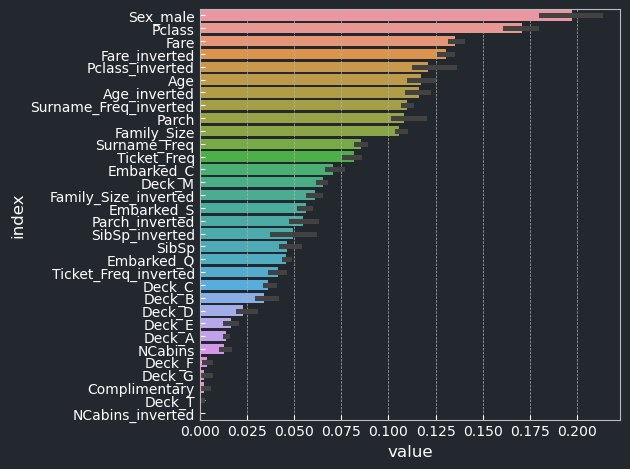

In [ ]:
sns.barplot(
    perm_imp,
    x="value",
    y="index",
    order=perm_imp.groupby("index")["value"].mean().sort_values(ascending=False).index,
)

<Axes: >

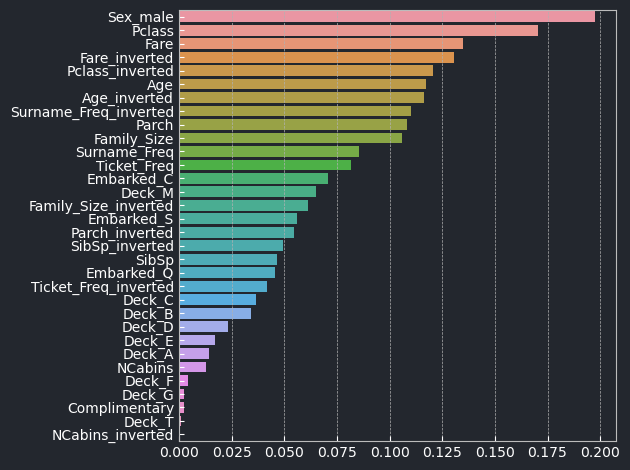

In [ ]:
sns.barplot(
    x=perm_pipe.importances_mean,
    y=X.columns,
    order=[
        item[1]
        for item in sorted(zip(perm_pipe.importances_mean, X.columns), reverse=True)
    ],
)

In [ ]:
val_key = sorted(zip(randf.feature_importances_, randf.feature_names_in_), reverse=True)
val_key = pd.DataFrame(val_key)

<Axes: xlabel='0', ylabel='1'>

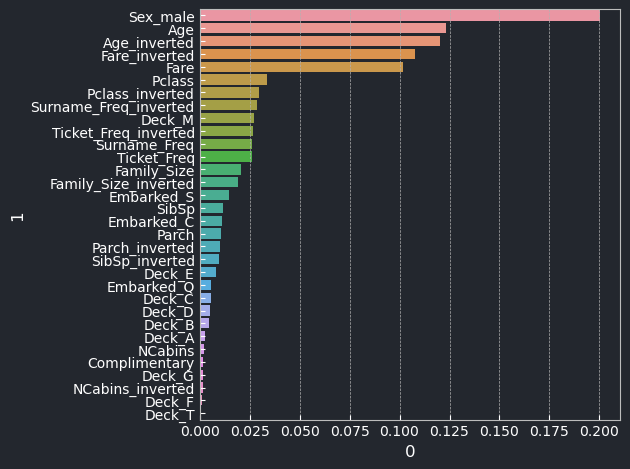

In [ ]:
sns.barplot(x=val_key[0], y=val_key[1])

In [ ]:
val_key = sorted(zip(model.feature_importances_), reverse=True)
val_key = pd.DataFrame(val_key)

In [ ]:
# val_key

0
0   0.048767
1   0.048298
2   0.042135
3   0.030249
4   0.029757
5   0.029633
6   0.028886
7   0.026803
8   0.026688
9   0.024388
10  0.024162
11  0.023392
12  0.023310
13  0.022271
14  0.021527
15  0.020577
16  0.020352
17  0.019645
18  0.019394
19  0.019071
20  0.017916
21  0.017402
22  0.016353
23  0.015967
24  0.015913
25  0.015447
26  0.015240
27  0.015135
28  0.015010
29  0.014897
30  0.014683
31  0.014493
32  0.014100
33  0.013990
34  0.013978
35  0.013974
36  0.013630
37  0.013342
38  0.013105
39  0.012711
40  0.012681
41  0.012648
42  0.012639
43  0.012369
44  0.012134
45  0.011923
46  0.011700
47  0.011676
48  0.011666
49  0.011611
50  0.011492
51  0.010527
52  0.010343

<Axes: xlabel='0'>

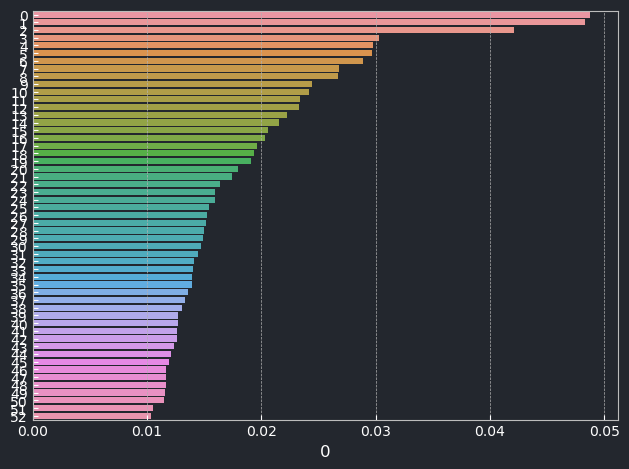

In [ ]:
sns.barplot(x=val_key[0], y=np.arange(val_key.shape[0]).astype(str))

In [ ]:
model.n_features_in_

53